Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest RMSE: 224.5272057968095
Random Forest MAE: 163.60033261052084
Gradient Boosting RMSE: 234.6085793529116
Gradient Boosting MAE: 172.54711647363615


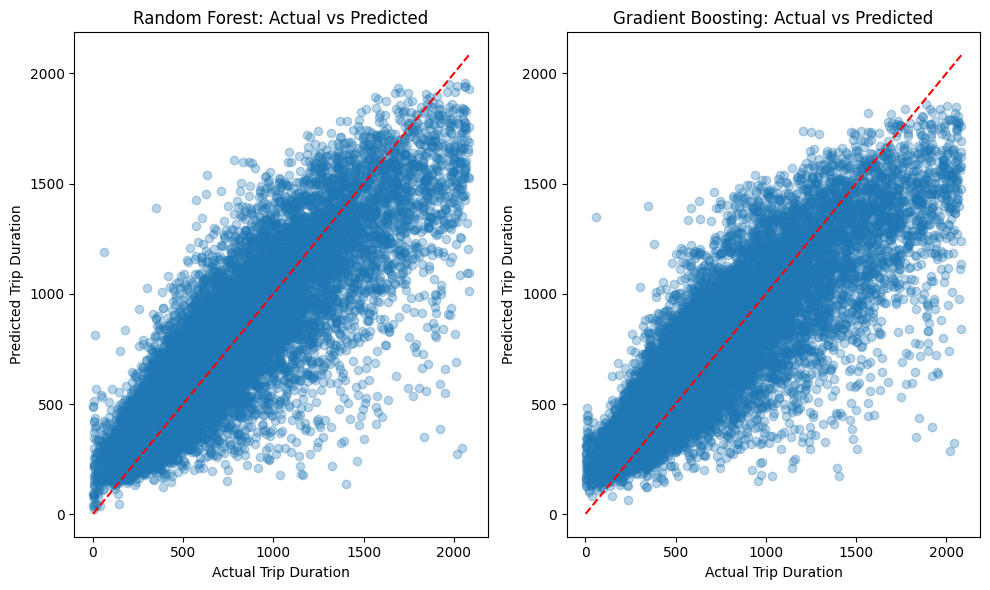

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset and reduce sample size
df = pd.read_csv('nyc_taxi_data_new.csv')
df = df.sample(frac=0.9, random_state=42)

# Convert pickup and dropoff datetime to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Extract temporal features
df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_year'] = df['pickup_datetime'].dt.year

# Vectorized Haversine distance calculation
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

df['haversine_distance'] = haversine_np(df['pickup_longitude'].values, df['pickup_latitude'].values,
                                        df['dropoff_longitude'].values, df['dropoff_latitude'].values)

# Vectorized Bearing calculation
def bearing_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    return (initial_bearing + 360) % 360

df['bearing'] = bearing_np(df['pickup_longitude'].values, df['pickup_latitude'].values,
                           df['dropoff_longitude'].values, df['dropoff_latitude'].values)

# Handle missing values
df = df.dropna()

# Drop unnecessary columns
df = df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'])

# Outlier detection using IQR
q1 = df['trip_duration'].quantile(0.25)
q3 = df['trip_duration'].quantile(0.75)
iqr = q3 - q1
df = df[(df['trip_duration'] >= (q1 - 1.5 * iqr)) & (df['trip_duration'] <= (q3 + 1.5 * iqr))]

# Split data into features and target variable
X = df.drop(columns=['trip_duration'])
y = df['trip_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

# Model Training
param_distributions_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions_rf,
                               cv=3, n_iter=5, n_jobs=-1, verbose=1, random_state=42)
random_rf.fit(X_train, y_train)
best_rf_model = random_rf.best_estimator_

# Train Gradient Boosting with reduced estimators
gb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Save the models
joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(gb_model, 'gradient_boosting_model.pkl')

# Model Evaluation
y_pred_rf = best_rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting MAE: {mae_gb}")

# Visualization: Model Performance Comparison
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.tight_layout()
plt.show()


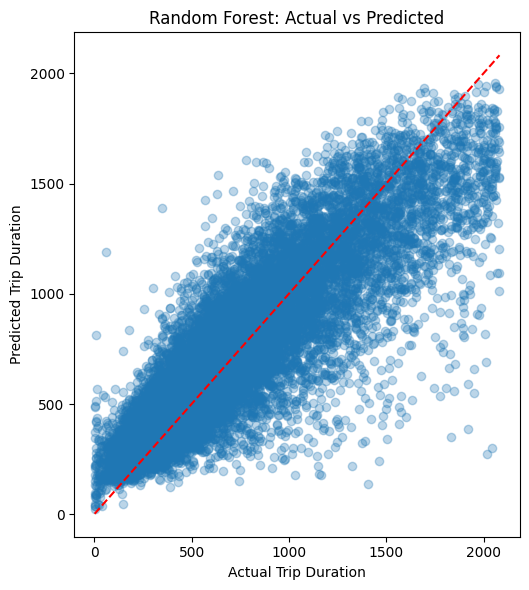

In [ ]:
# Visualization: Model Performance Comparison
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.title('Random Forest: Actual vs Predicted perfomance')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.subplot(1, 2, 2)
# plt.scatter(y_test, y_pred_gb, alpha=0.3)
# plt.title('Gradient Boosting: Actual vs Predicted')
# plt.xlabel('Actual Trip Duration')
# plt.ylabel('Predicted Trip Duration')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare data for GAN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define GAN components
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = X_train.shape[1]
output_dim = 1
lr = 0.0002
num_epochs = 200

# Initialize models
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(input_dim + output_dim)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for real_data, real_labels in train_loader:
        batch_size = real_data.size(0)

        # Real data
        real_labels = real_labels.view(-1, 1)
        real_input = torch.cat((real_data, real_labels), dim=1)
        real_target = torch.ones(batch_size, 1)

        # Fake data
        noise = torch.randn(batch_size, input_dim)
        fake_labels = generator(noise).detach()
        fake_input = torch.cat((noise, fake_labels), dim=1)
        fake_target = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_input), real_target)
        fake_loss = criterion(discriminator(fake_input), fake_target)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        generated_labels = generator(noise)
        g_input = torch.cat((noise, generated_labels), dim=1)
        g_loss = criterion(discriminator(g_input), real_target)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save the GAN models
torch.save(generator.state_dict(), 'gan_generator.pth')
torch.save(discriminator.state_dict(), 'gan_discriminator.pth')

# Generate synthetic data
with torch.no_grad():
    synthetic_noise = torch.randn(X_train.shape[0], input_dim)
    synthetic_labels = generator(synthetic_noise).numpy()
    synthetic_data = np.hstack((synthetic_noise.numpy(), synthetic_labels))

# Augment original data with synthetic data
augmented_X_train = np.vstack((X_train, synthetic_data[:, :-1]))
augmented_y_train = np.hstack((y_train, synthetic_data[:, -1]))
